# Constant-Volume Reactor

This Jupyter Notebook was written by Dan Haworth. It is intended as a tutorial to be used in parallel with Chapter 4 of the book "An Introduction to Combustion: Concepts and Applications" by Stephen R. Turns and Daniel C. Haworth. That book is referred to as "Turns 4th ed." throughout this Notebook.

This Notebook was last updated 11 February 2020.

The objective of this tutorial is to provide an example of how to compute the time evolution of composition and thermodynamic properties (e.g., temperature and pressure) for an ideal-gas mixture, starting from an initial fuel+air reactant mixture, and through the final equilibrium products of combustion. A constant-volume adiabatic combustion process is considered. Cantera reactors/reactor networks and Pandas DataFrames are introduced in this context. Both of those will be useful in subsequent tutorials. We will use the thermodynamic properties and reaction mechanism that are included in gri30.cti.

The reader should be familiar with the material in the previous Notebook (4_2_ODE_integration_thermal_NO) before working through this Notebook.

## 1. Motivation and scope

In the previous tutorial Notebook (4_2_ODE_integration_thermal_NO), we manually coded the system of equations governing the time evolution of species molar concentrations for a relatively simple system, and integrated those in time using SciPy's `solve_ivp()` function. Here we use built-in Cantera objects to do something similar for a much larger reaction mechanism: GRI-Mech 3.0.

Specifically, we consider the time evolution of an ideal-gas mixture for a constant-volume fixed-mass adiabatic combustion process, starting from a specified fuel-air reactant mixture, and eventually reaching equilibrium products of combustion. The equations governing the time evolution of species molar concentrations are identical to those given in Section 1 of Notebook 4_2_ODE_integration_thermal_NO:

$$ \frac{d[X_i]}{dt} = \dot \omega _ i \ , \ i = 1 , \ldots , N_{spec} $$

However, here we need one more ingredient: an energy, or temperature, equation. That equation is developed in Chapter 6, so we are jumping ahead a bit. The particular form of the energy (temperature) equation that we need is Eq. (6.29) or (6.20), with $ \dot Q = 0 $ (adiabatic). Here the mass and volume are constant, so that the mixture pressure follows from the composition, temperature, and the ideal-gas equation of state.

The reason that we introduce this here, rather than waiting until Chapter 6, is that it will facilitate our subsequent discussion of Chapters 4 and 5. The next Chapter 4 tutorial Notebook deals with chemical time scales: i.e., the rates at which individual chemical reactions proceed. And in Chapter 5, we will discuss the sequence of events by which an initial reactant mixture that contains one set of species or molecules (e.g.,  fuel and air) eventually is converted to a product mixture that contains a different set of species or molecules. For these purposes, it will be useful to be able to compute and examine the time history of the composition and temperature of a reacting mixture for a realistic reaction mechanism.

## 2. Simulating a constant-volume adiabatic reactor using Cantera

In [1]:
# access modules
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # this will be the first use of Pandas in our tutorial Notebooks
import time         # this provides utilities that can be used to monitor computer time, among other things
                    # since no prefix is specified, it will be necessary to use the prefix "time." to access time functions

# report Cantera version
print("Running Cantera version: {}".format(ct.__version__))

Running Cantera version: 2.4.0


In [2]:
# define an ideal-gas mixture named "gas" using Cantera's "Solution" object and GRI-Mech 3.0
gas = ct.Solution('gri30.cti')

In [3]:
# specify the initial temperature, pressure, and composition
# a fuel-lean mixture of propane and air is considered here
T_0 = 1000.      # (K)
P_0 = ct.one_atm # (Pa)

# GRI-Mech 3.0 is not really intended to be used as a reaction mechanism for propane
#   (it is intended to be used for natural gas, which is mostly methane), but it will suffice for the present purpose
fuel = 'C3H8'
air  = {'O2':1.0, 'N2':3.76}
phi  = 0.8

gas.TP = T_0, P_0
gas.set_equivalence_ratio(phi,fuel,air)

# save the initial mixture composition (species mole fractions) for subsequent use below
X_0 = gas.X

# print the full initial state of the mixture
gas()


  gri30:

       temperature            1000  K
          pressure          101325  Pa
           density        0.357634  kg/m^3
  mean mol. weight         29.3465  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy      7.0376e+05        2.065e+07     J
   internal energy      4.2044e+05        1.234e+07     J
           entropy          8270.7        2.427e+05     J/K
    Gibbs function      -7.567e+06       -2.221e+08     J
 heat capacity c_p          1288.3        3.781e+04     J/K
 heat capacity c_v          1004.9        2.949e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                O2       0.203252         0.221621          -28.159
                N2       0.764228         0.729513         -25.1194
              C3H8      0.0325203        0.0488655         -54.9755
     [  +50 minor]        

### 2.1 Cantera reactors and reactor networks

The Cantera objects that we need are [`Reactor()`](https://cantera.org/documentation/docs-2.4/sphinx/html/cython/zerodim.html#reactor) (Reactors) and [`ReactorNet()`](https://cantera.org/documentation/docs-2.4/sphinx/html/cython/zerodim.html#cantera.ReactorNet) (Reactor Networks). Several kinds of reactors are available in Cantera. To see the full list of Cantera attributes:

In [4]:
# show all available Cantera attributes
dir(ct)

['Arrhenius',
 'AxisymmetricStagnationFlow',
 'Boundary1D',
 'BurnerFlame',
 'CanteraError',
 'CarbonDioxide',
 'ChebyshevReaction',
 'ChemicallyActivatedReaction',
 'ConstPressureReactor',
 'ConstantCp',
 'CounterflowDiffusionFlame',
 'CounterflowPremixedFlame',
 'CounterflowTwinPremixedFlame',
 'Domain1D',
 'DustyGas',
 'DustyGasTransport',
 'Element',
 'ElementaryReaction',
 'Falloff',
 'FalloffReaction',
 'FlameBase',
 'FlowDevice',
 'FlowReactor',
 'FreeFlame',
 'FreeFlow',
 'Func1',
 'GasTransportData',
 'Heptane',
 'Hfc134a',
 'Hydrogen',
 'IdealGasConstPressureReactor',
 'IdealGasFlow',
 'IdealGasReactor',
 'ImpingingJet',
 'Inlet1D',
 'Interface',
 'InterfaceKinetics',
 'InterfacePhase',
 'InterfaceReaction',
 'IonBurnerFlame',
 'IonFlameBase',
 'IonFlow',
 'IonFreeFlame',
 'Kinetics',
 'MassFlowController',
 'Methane',
 'Mixture',
 'NasaPoly2',
 'Nitrogen',
 'Outlet1D',
 'OutletReservoir1D',
 'Oxygen',
 'PlogReaction',
 'PressureController',
 'PureFluid',
 'Quantity',
 'React

Here we will define an ideal-gas adiabatic contant-volume reactor using [`IdealGasReactor()`](https://cantera.org/documentation/docs-2.4/sphinx/html/cython/zerodim.html#idealgasreactor):

In [5]:
help(ct.IdealGasReactor)

Help on class IdealGasReactor in module cantera._cantera:

class IdealGasReactor(Reactor)
 |  A constant volume, zero-dimensional reactor for ideal gas mixtures.
 |  
 |  Method resolution order:
 |      IdealGasReactor
 |      Reactor
 |      ReactorBase
 |      builtins.object
 |  
 |  Static methods defined here:
 |  
 |  __new__(*args, **kwargs) from builtins.type
 |      Create and return a new object.  See help(type) for accurate signature.
 |  
 |  ----------------------------------------------------------------------
 |  Data and other attributes defined here:
 |  
 |  reactor_type = 'IdealGasReactor'
 |  
 |  ----------------------------------------------------------------------
 |  Methods inherited from Reactor:
 |  
 |  __init__(...)
 |      :param contents:
 |          Reactor contents. If not specified, the reactor is initially empty.
 |          In this case, call `insert` to specify the contents.
 |      :param name:
 |          Used only to identify this reactor in out

In [6]:
# define a reactor that is filled with the ideal-gas mixture "gas",
#   and name it "Constant-volume reactor"
reactor = ct.IdealGasReactor(contents=gas,name="Constant-volume reactor")

# show all available attributes for "reactor"
dir(reactor)

['T',
 'Y',
 '__class__',
 '__copy__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '_add_inlet',
 '_add_outlet',
 '_add_wall',
 'add_sensitivity_reaction',
 'add_sensitivity_species_enthalpy',
 'chemistry_enabled',
 'component_index',
 'component_name',
 'density',
 'energy_enabled',
 'get_state',
 'inlets',
 'insert',
 'kinetics',
 'mass',
 'n_vars',
 'name',
 'outlets',
 'reactor_type',
 'syncState',
 'thermo',
 'volume',
 'walls']

To compute the time evolution of the composition, temperature, and pressure of the gas mixture in the reactor, the reactor needs to be part of a "reactor network". In this case, the reactor network contains a single reactor:

In [7]:
# add "reactor" to a reactor network named "reactorNetwork"
reactorNetwork = ct.ReactorNet([reactor])

# show all available attributes for "reactorNetwork"
dir(reactorNetwork)

['__class__',
 '__copy__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'add_reactor',
 'advance',
 'advance_to_steady_state',
 'atol',
 'atol_sensitivity',
 'component_name',
 'get_state',
 'max_err_test_fails',
 'n_sensitivity_params',
 'n_vars',
 'reinitialize',
 'rtol',
 'rtol_sensitivity',
 'sensitivities',
 'sensitivity',
 'sensitivity_parameter_name',
 'set_initial_time',
 'set_max_time_step',
 'step',
 'time',
 'verbose']

In the following, we will compute as functions of time the [`n_vars`](https://cantera.org/documentation/docs-2.4/sphinx/html/cython/zerodim.html#cantera.Reactor.n_vars) state variables associated with "reactor", and we will plot as functions of time a subset of those state variables.

In [8]:
# print the number of state variables associated with "reactor"
reactor.n_vars

56

In [9]:
# print the names of the n_vars state variables associated with "reactor"
for i in range(reactor.n_vars):
    print(' {:4d} {:10s} '.format(i,reactor.component_name(i) ) )

    0 mass       
    1 volume     
    2 temperature 
    3 H2         
    4 H          
    5 O          
    6 O2         
    7 OH         
    8 H2O        
    9 HO2        
   10 H2O2       
   11 C          
   12 CH         
   13 CH2        
   14 CH2(S)     
   15 CH3        
   16 CH4        
   17 CO         
   18 CO2        
   19 HCO        
   20 CH2O       
   21 CH2OH      
   22 CH3O       
   23 CH3OH      
   24 C2H        
   25 C2H2       
   26 C2H3       
   27 C2H4       
   28 C2H5       
   29 C2H6       
   30 HCCO       
   31 CH2CO      
   32 HCCOH      
   33 N          
   34 NH         
   35 NH2        
   36 NH3        
   37 NNH        
   38 NO         
   39 NO2        
   40 N2O        
   41 HNO        
   42 CN         
   43 HCN        
   44 H2CN       
   45 HCNN       
   46 HCNO       
   47 HOCN       
   48 HNCO       
   49 NCO        
   50 N2         
   51 AR         
   52 C3H7       
   53 C3H8       
   54 CH2CHO     
   55 CH3

The reactor state variables are mass, volume, temperature, and the mass fractions of the 53 species in gri30.cti. Currently all values are equal to zero, except for the reactor mass, volume, temperature, and mass fractions of the three reactant species: C3H8, O2, and N2:

In [10]:
# print the values of the n_vars state variables associated with "reactor"
reactor.get_state()

array([3.57634339e-01, 1.00000000e+00, 1.00000000e+03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.21621470e-01, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 7.29513020e-01, 0.00000000e+00,
       0.00000000e+00, 4.88655104e-02, 0.00000000e+00, 0.00000000e+00])

It is important to note that the reactor composition is expressed as species mass fractions, not mole fractions.

### 2.2 Pandas `DataFrame()`

Pandas [`DataFrame()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) provides a general data structure that is useful for manipulating and plotting large quantities of data, such as those associated with the time evolution of a reacting mixture using a large reaction mechanism.

In [11]:
# create a list of all variables (named "stateVariableNames") for which we will compute and store time-dependent data
# here that is the n_vars reactor state variables
stateVariableNames = [reactor.component_name(i) for i in range(reactor.n_vars)]

# create a Pandas DataFrame named "timeHistory", using the state variable names as column headings
timeHistory = pd.DataFrame(columns=stateVariableNames)

# print the DataFrame
# currently it contains only the n_vars column headings
timeHistory

,mass,volume,temperature,H2,H,O,O2,OH,H2O,HO2,...,HCNO,HOCN,HNCO,NCO,N2,AR,C3H7,C3H8,CH2CHO,CH3CHO


As we will see shortly, `DataFrame()` will allow us to add a new row at each instant in time as the system evolves in time, and to assign an index to each row that corresponds to the time variable.

### 2.3 Time evolution from reactants to equilibrium products

This is an initial-value problem. Starting from the initial mixture state at time t=0 (reactants at the specified pressure and temperature), we will integrate the system of coupled nonlinear ordinary differential equations (ODEs) corresponding to a constant-volume adiabatic reactor in time until the system reaches a steady state that corresponds to chemical equilbrium. An appropriate system of ODEs can be found in Chapter 6 of Turns 4th ed. (see Section 1 above). In contrast to the previous tutorial Notebook, we do not need to provide the ODEs explicitly here; they are embedded in the ideal-gas constant-volume reactor and reactor network that we have defined.

As noted in the previous tutorial Notebook (4_2_ODE_integration_thermal_NO), special algorithms are needed to efficiently and stably integrate the "stiff" system of nonlinear ODEs that arise in chemically reacting systems. These usually involve variants of Newton's method (see Appendix E, Turns 4th ed.). Details of the algorithms that are used in Cantera are beyond the scope of the current discussion. Briefly, the system is advanced in time starting with a very small internal computational time step. The computational time step then varies as the time integration proceeds, in a manner that aims to minimize the overall computational time while ensuring stability. The integration proceeds until the user-specified end time is reached.
Here the [`step()`](https://cantera.org/documentation/docs-2.4/sphinx/html/cython/zerodim.html#cantera.ReactorNet.step) attribute is used to perform the time integration, with default values for all internal numerical parameters.

In [12]:
# let's see what "step" does
help(reactorNetwork.__class__.step)

Help on method_descriptor:

step(...)
    ReactorNet.step(self)
    
    Take a single internal time step. The time after taking the step is
    returned.



With `step()`, the computational time step in seconds is determined internally by the solver. The initial time step can be printed out by performing a single computational time step:

In [13]:
# perform a single time step, and print the initial value of the time step (s) that is used in the time integration
reactorNetwork.step()

7.250985275527494e-13

So, the solution has advanced in time from the initial condition at time t=0 to the above instant in time. The temperature and composition of the mixture have changed from their initial values, but not by much:

In [14]:
# print the current reactor state
reactor.get_state()

array([3.57634339e-01, 1.00000000e+00, 1.00000000e+03, 1.20741438e-28,
       1.14369790e-22, 6.33435125e-27, 2.21621470e-01, 1.11198220e-26,
       1.67919998e-32, 1.51689700e-17, 3.49054985e-27, 3.01260934e-62,
       6.72764468e-39, 1.99216310e-39, 1.41603663e-40, 6.42320299e-17,
       4.33092081e-26, 3.32023685e-43, 3.06081692e-44, 6.08299909e-39,
       1.93343643e-26, 6.47516723e-47, 1.84923486e-27, 1.42659920e-46,
       2.50899377e-66, 2.60061491e-40, 9.64872691e-45, 3.26786765e-23,
       1.24157886e-16, 1.27031112e-36, 1.79997450e-70, 4.68163890e-57,
       2.35858534e-88, 1.26419789e-46, 1.00199214e-51, 3.32063349e-88,
       0.00000000e+00, 4.21748333e-31, 2.65140590e-46, 5.95020454e-62,
       1.41717002e-26, 6.50694005e-59, 1.25031214e-73, 5.12153739e-48,
       3.71156762e-60, 4.08560705e-45, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 3.23401890e-78, 7.29513020e-01, 0.00000000e+00,
       1.98071395e-17, 4.88655104e-02, 6.16173733e-50, 2.11775451e-45])

It can be useful to monitor the computer time required to solve a problem, especially when we eventually get to larger problems that will require non-negligible amounts of computer time. The "time" module loaded earlier provides a way to do this.

In [15]:
# list all attributes associated with "time"
dir(time)

['_STRUCT_TM_ITEMS',
 '__doc__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'altzone',
 'asctime',
 'clock',
 'ctime',
 'daylight',
 'get_clock_info',
 'gmtime',
 'localtime',
 'mktime',
 'monotonic',
 'monotonic_ns',
 'perf_counter',
 'perf_counter_ns',
 'process_time',
 'process_time_ns',
 'sleep',
 'strftime',
 'strptime',
 'struct_time',
 'thread_time',
 'thread_time_ns',
 'time',
 'time_ns',
 'timezone',
 'tzname']

The attribute that we will use is `time()`:

In [16]:
# print help for attribute "time"
help(time.time)

Help on built-in function time in module time:

time(...)
    time() -> floating point number
    
    Return the current time in seconds since the Epoch.
    Fractions of a second may be present if the system clock provides them.



The example below illustrates how to use `time()` to monitor the computer time required to solve the current initial-value problem.

Before beginning the time integration, we first re-initialize the reactor to the desired initial state, since we already took one (very small) time step above.

In [17]:
# re-initialize the reactor
gas.TP = T_0, P_0
gas.set_equivalence_ratio(phi,fuel,air)

reactor = ct.IdealGasReactor(contents=gas,name="Constant-volume reactor")

reactorNetwork = ct.ReactorNet([reactor])

# confirm that the reactor is back to the desired initial state
reactor.get_state()

array([3.57634339e-01, 1.00000000e+00, 1.00000000e+03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.21621470e-01, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 7.29513020e-01, 0.00000000e+00,
       0.00000000e+00, 4.88655104e-02, 0.00000000e+00, 0.00000000e+00])

In [18]:
# add a row to "timeHistory" that corresponds to the initial condition
t = 0.
timeHistory.loc[t] = reactor.get_state()

# print "timeHistory"
timeHistory

,mass,volume,temperature,H2,H,O,O2,OH,H2O,HO2,...,HCNO,HOCN,HNCO,NCO,N2,AR,C3H7,C3H8,CH2CHO,CH3CHO
0.0,0.357634,1.0,1000.0,0.0,0.0,0.0,0.221621,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.729513,0.0,0.0,0.048866,0.0,0.0


The first row now contains the specified initial condition. Note also that a time stamp has been added to the row (see the far left column). 

Now solve the initial-value problem, and monitor the computer time required.

In [19]:
# specify the integration end time in seconds
# some trial-and-error may be needed to find an appropriate end-time value that allows the system to reach steady state,
#   without wasting computational effort by computing beyond the steady state
# there are other ways to do this that directly monitor and detect when steady state has been reached, as
#   we will see in subsequent tutorials
t_end = 1.0 # (s)

# get the current computer time "ctim0"
# this will be used to monitor the computer time required to solve the initial-value problem
ctim0 = time.time()

# perform the time integration
# the variable "counter" is used to control how often the reactor state is saved to "timeHistory":
#   here it is saved once every 10 time steps
counter = 1;
while(t <= t_end):
# the following line advances the solution over one time step
# the size of the time step is determined internally by the ODE integrator
# the end-of-timestep time value is returned in "t"
    t = reactorNetwork.step()
# the expression "counter%10" gives the remainder in an integer division of "counter" by 10
# the reactor state is saved to "timeHistory" (a new row is created) once every 10 time steps,
#   and the new row is indexed by the current integration time
    if (counter%10 == 0):
        timeHistory.loc[t] = reactorNetwork.get_state()
    counter+=1

# make sure that the final time step is included in timeHistory
timeHistory.loc[t] = reactorNetwork.get_state()

# get the current computer time "ctim1"
# the computer time needed to solve the initial-value problem is then the difference between ctim1 and ctim0
ctim1 = time.time()
ctime = ctim1 - ctim0

# print the final integration time and computer time required
print('Reached time {:.3e} seconds. Needed {:3.2f}s to compute'.format(t,ctime))

Reached time 1.086e+00 seconds. Needed 0.58s to compute


Note that the final integration time reached is somwhat longer than the specified end time. The computer time required will depend on what computer you are using, but should be one second or less for this problem.

In [20]:
# print the time history
timeHistory

,mass,volume,temperature,H2,H,O,O2,OH,H2O,HO2,...,HCNO,HOCN,HNCO,NCO,N2,AR,C3H7,C3H8,CH2CHO,CH3CHO
0.000000e+00,0.357634,1.0,1000.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.221621,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.729513,0.000000e+00,0.000000e+00,4.886551e-02,0.000000e+00,0.000000e+00
3.967925e-07,0.357634,1.0,999.999999,6.313572e-16,2.924374e-15,8.368941e-16,0.221621,2.109992e-15,6.074711e-16,1.264952e-11,...,1.510780e-52,6.909730e-50,4.592158e-50,2.017869e-48,0.729513,0.000000e+00,9.545926e-12,4.886551e-02,4.831046e-25,2.075182e-23
1.832404e-06,0.357634,1.0,999.999996,3.805471e-14,3.567348e-14,3.033108e-14,0.221621,5.154827e-14,6.561005e-14,1.194051e-10,...,7.735071e-48,1.439115e-46,1.329011e-46,8.630381e-45,0.729513,0.000000e+00,2.976447e-11,4.886551e-02,3.347041e-22,1.271310e-20
5.398316e-06,0.357634,1.0,999.999988,4.261473e-13,1.048181e-13,1.448408e-13,0.221621,2.487554e-13,1.208508e-12,6.344306e-10,...,9.403957e-45,2.165230e-44,6.137818e-44,1.305402e-42,0.729513,0.000000e+00,4.656491e-11,4.886551e-02,2.327437e-20,4.826689e-19
1.215255e-05,0.357634,1.0,999.999975,1.686063e-12,1.403698e-13,2.228163e-13,0.221621,4.350911e-13,6.225108e-12,1.953056e-09,...,6.362601e-43,5.164367e-43,3.533888e-42,2.859418e-41,0.729513,0.000000e+00,5.563038e-11,4.886551e-02,2.969723e-19,3.018448e-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5.643498e-01,0.357634,1.0,2692.743285,3.386152e-04,8.130434e-05,2.376716e-03,0.045573,8.251609e-03,7.172808e-02,1.059574e-05,...,1.757479e-14,3.339082e-11,4.456769e-09,9.696190e-10,0.722913,4.164614e-27,1.629511e-43,3.086357e-45,8.295948e-23,1.131839e-24
5.693185e-01,0.357634,1.0,2692.743219,3.386152e-04,8.130432e-05,2.376714e-03,0.045573,8.251606e-03,7.172808e-02,1.059574e-05,...,1.757482e-14,3.339088e-11,4.456778e-09,9.696208e-10,0.722913,4.164614e-27,1.629511e-43,3.086358e-45,8.295945e-23,1.131839e-24
5.774652e-01,0.357634,1.0,2692.743218,3.386152e-04,8.130432e-05,2.376714e-03,0.045573,8.251606e-03,7.172808e-02,1.059574e-05,...,1.757483e-14,3.339089e-11,4.456778e-09,9.696208e-10,0.722913,4.164614e-27,1.629511e-43,3.086358e-45,8.295945e-23,1.131839e-24
6.163602e-01,0.357634,1.0,2692.743218,3.386152e-04,8.130432e-05,2.376714e-03,0.045573,8.251606e-03,7.172808e-02,1.059574e-05,...,1.757483e-14,3.339089e-11,4.456778e-09,9.696208e-10,0.722913,4.164614e-27,1.629511e-43,3.086358e-45,8.295945e-23,1.131839e-24


There is one row in timeHistory for each instant in time at which the solution was saved. This can also be written to an external file:

In [21]:
# save the time history to an Excel-compatible file
# further post-processing (e.g., plot generation) can then be done using Excel, or in the current Notebook (see below)
timeHistory.to_csv("time_history.csv")

Let's take a look at one of the key state variables: the mixture temperature.

In [22]:
# print the time evolution of temperature
timeHistory['temperature']

0.000000e+00    1000.000000
3.967925e-07     999.999999
1.832404e-06     999.999996
5.398316e-06     999.999988
1.215255e-05     999.999975
                   ...     
5.643498e-01    2692.743285
5.693185e-01    2692.743219
5.774652e-01    2692.743218
6.163602e-01    2692.743218
1.086355e+00    2692.743218
Name: temperature, Length: 295, dtype: float64

Note that the temperature decreases slightly initially, before starting to increase toward the final (equilibrium) temperature. This reflects the endothermic nature of the intial fuel and oxidizer decomposition reactions. There is also an overshoot in temperature, before the temperature settles to its steady-state value. That will be more evident in the plots that follow.

Further discussion of the time evolution of the system follows the plots that are generated below. First, we confirm that the steady-state solution from the time integration is consistent with chemical equilibrium. This should always be the case, provided that we integrated long enough in time to reach equilibrium.

### 2.4 Consistency between chemical kinetics and thermodynamics

In [23]:
# print the final mixture state from the time integration
gas()


  gri30:

       temperature         2692.74  K
          pressure          287369  Pa
           density        0.357634  kg/m^3
  mean mol. weight          27.863  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy       1.224e+06         3.41e+07     J
   internal energy      4.2044e+05        1.171e+07     J
           entropy          9683.8        2.698e+05     J/K
    Gibbs function     -2.4852e+07       -6.925e+08     J
 heat capacity c_p            1461        4.071e+04     J/K
 heat capacity c_v          1162.6        3.239e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                H2     0.00468025      0.000338615          -24.789
                 H     0.00224754      8.13043e-05         -12.3945
                 O     0.00413905       0.00237671         -16.0252
                O2      0.

In [24]:
# reset "gas" to to the initial reactant mixture
gas.TPX = T_0, P_0, X_0
gas()


  gri30:

       temperature            1000  K
          pressure          101325  Pa
           density        0.357634  kg/m^3
  mean mol. weight         29.3465  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy      7.0376e+05        2.065e+07     J
   internal energy      4.2044e+05        1.234e+07     J
           entropy          8270.7        2.427e+05     J/K
    Gibbs function      -7.567e+06       -2.221e+08     J
 heat capacity c_p          1288.3        3.781e+04     J/K
 heat capacity c_v          1004.9        2.949e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                O2       0.203252         0.221621          -28.159
                N2       0.764228         0.729513         -25.1194
              C3H8      0.0325203        0.0488655         -54.9755
     [  +50 minor]        

In [25]:
# compute the equilibrium composition and temperature, for a constant-volume adiabatic process
#   (contant mixture internal energy and volume)
gas.equilibrate('UV')
gas()


  gri30:

       temperature         2692.74  K
          pressure          287369  Pa
           density        0.357634  kg/m^3
  mean mol. weight          27.863  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy       1.224e+06         3.41e+07     J
   internal energy      4.2044e+05        1.171e+07     J
           entropy          9683.8        2.698e+05     J/K
    Gibbs function     -2.4852e+07       -6.925e+08     J
 heat capacity c_p            1461        4.071e+04     J/K
 heat capacity c_v          1162.6        3.239e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                H2     0.00468026      0.000338615          -24.789
                 H     0.00224754      8.13044e-05         -12.3945
                 O     0.00413906       0.00237672         -16.0252
                O2      0.

The steady-state solution from the time integration agrees with the equilibrium state, to within approximately five significant figures. Note that the final product pressure is higher than the initial reactant pressure for this constant-volume adiabatic process. And note that the product mixture mass-specific internal energy (J/kg) is equal to that for the initial reactants, as it must be for constant-volume adiabatic combustion.

### 2.5 Time evolution plots

As we work through Chapters 5 and 6, and through subsequent tutorial Notebooks, we will look more closely at how the composition of the gas mixture, in particular, evolves from initial fuel+air reactants to final equilibrium products. For now, we will look at temperature and a few key species, including NO.

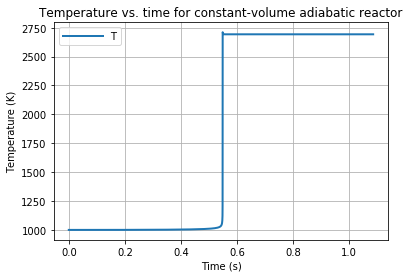

In [26]:
# plot the time evolution of temperature
fig, ax = plt.subplots()
ax.plot(timeHistory.index, timeHistory['temperature'], label='T', lw=2)
ax.set(xlabel='Time (s)',
       ylabel='Temperature (K)',
       title ='Temperature vs. time for constant-volume adiabatic reactor')
ax.legend(handlelength=4,loc='best')
ax.grid(True)
fig.savefig("T_vs_t_vconst.pdf")

It can be seen that the temperature remains close to its initial value for approximately the first 0.5 s (in fact, at first the temperature decreases slightly from the prescribed initial value, as discussed earlier), then rapidly increases at approximately 0.55 s (the *ignition delay time* - we will discuss that further in Chapter 6), slightly overshoots the final temperature, then settles to the final steady-state (equilibrium) value. The approximately constant temperature until 0.5 s might suggest that little is happening up to that point, but in fact, much is happening during this *induction period*, as we will see below, and discuss further in Chapters 5 and 6.

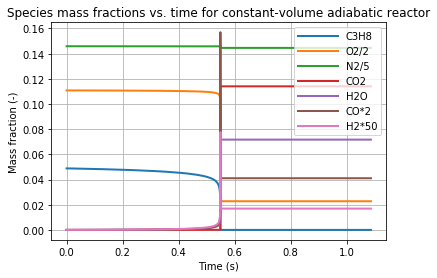

In [27]:
# plot the time evolution of major species mass fractions, plus CO and H2
# individual species mass fractions are scaled so that they can be seen more clearly on a single figure
fig, ax = plt.subplots()
ax.plot(timeHistory.index, timeHistory['C3H8'],  label='C3H8', lw=2)
ax.plot(timeHistory.index, timeHistory['O2']/2., label='O2/2', lw=2)
ax.plot(timeHistory.index, timeHistory['N2']/5., label='N2/5', lw=2)
ax.plot(timeHistory.index, timeHistory['CO2'],   label='CO2',  lw=2)
ax.plot(timeHistory.index, timeHistory['H2O'],   label='H2O',  lw=2)
ax.plot(timeHistory.index, timeHistory['CO']*2., label='CO*2', lw=2)
ax.plot(timeHistory.index, timeHistory['H2']*50.,label='H2*50',lw=2)
ax.set(xlabel='Time (s)',
       ylabel='Mass fraction (-)',
       title ='Species mass fractions vs. time for constant-volume adiabatic reactor')
ax.legend(handlelength=4,loc='best')
ax.grid(True)
fig.savefig("Ymajor_vs_t_vconst.pdf")

It can be seen that there is a steady decrease in fuel mass fraction over the first 0.5 s, and that the rate of decrease becomes faster as the main ignition time is approached. There is a similar trend for O2, although it is not as apparent. To see more clearly what is happening immediately before and after ignition, we can zoom in over that time interval:

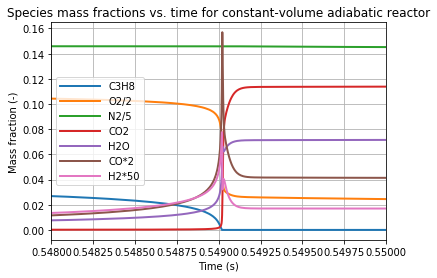

In [28]:
# plot the time evolution of major species mass fractions, plus CO and H2
# individual species mass fractions are scaled so that they can be seen more clearly on a single figure
fig, ax = plt.subplots()
ax.plot(timeHistory.index, timeHistory['C3H8'],  label='C3H8', lw=2)
ax.plot(timeHistory.index, timeHistory['O2']/2., label='O2/2', lw=2)
ax.plot(timeHistory.index, timeHistory['N2']/5., label='N2/5', lw=2)
ax.plot(timeHistory.index, timeHistory['CO2'],   label='CO2',  lw=2)
ax.plot(timeHistory.index, timeHistory['H2O'],   label='H2O',  lw=2)
ax.plot(timeHistory.index, timeHistory['CO']*2., label='CO*2', lw=2)
ax.plot(timeHistory.index, timeHistory['H2']*50.,label='H2*50',lw=2)
ax.set(xlim=(0.548,0.550),
       xlabel='Time (s)',
       ylabel='Mass fraction (-)',
       title ='Species mass fractions vs. time for constant-volume adiabatic reactor')
ax.legend(handlelength=4,loc='best')
ax.grid(True)
fig.savefig("Ymajor_vs_t_vconst_zoom.pdf")

Now more structure is evident. It can be seen that the ignition event is not instantaneous, although it is quite short compared to the time leading up to ignition. CO and H2 start to increase prior to ignition, then fall to their equilibrium values as the conversion to CO2 and H2O completes. The conversion to CO2 is relatively slow: it takes longer for CO2 to reach its equilibrium value, compared to other major species. We will see this again in subsequent tutorials.

Finally, we look at the time evolution of NO:

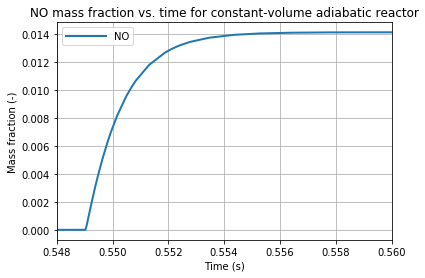

In [29]:
# plot the time evolution of NO
fig, ax = plt.subplots()
ax.plot(timeHistory.index, timeHistory['NO'],  label='NO', lw=2)
ax.set(xlim=(0.548,0.560),
       xlabel='Time (s)',
       ylabel='Mass fraction (-)',
       title ='NO mass fraction vs. time for constant-volume adiabatic reactor')
ax.legend(handlelength=4,loc='best')
ax.grid(True)
fig.savefig("NO_vs_t_vconst_zoom.pdf")

This confirms that no significant NO formation starts after after the main conversion from reactants to major-species products has completed (see Notebook 4_2_ODE_integration_thermal_NO). The rate of NO formation is much faster here compared to what was seen in the previous tutorial Notebook, though. Here the product temperature and pressure are higher, because a constant-volume combustion process was considered. Also, other NO formation pathways in addition to thermal NO are considered in GRI-Mech 3.0, although thermal NO dominates for the conditions simulated here.